In [1]:
from farm.modeling.tokenization import Tokenizer
from farm.data_handler.processor import TextClassificationProcessor
from farm.data_handler.data_silo import DataSilo
from farm.data_handler.data_silo import StreamingDataSilo
from farm.modeling.language_model import LanguageModel
from farm.modeling.prediction_head import TextClassificationHead
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.optimization import initialize_optimizer
from farm.train import Trainer
from farm.utils import MLFlowLogger

In [2]:
from farm.eval_pamela import Evaluator
from torch.utils.data import DataLoader, Dataset

In [3]:
import csv
import torch
import pandas as pd
import pickle
import numpy as np

In [4]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [5]:
def get_trainer(space):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print("Devices available: {}".format(device))

    tokenizer = Tokenizer.load('')

    LABEL_LIST = ['0','1']
    processor = TextClassificationProcessor(tokenizer=tokenizer,
                                            max_seq_len=512,
                                            data_dir="",
                                            train_filename="",
                                            test_filename="",
                                            label_list=LABEL_LIST,
                                            metric="f1_macro",
                                            text_column_name="",
                                            label_column_name="",
                                           dev_split=0)

    BATCH_SIZE = 64

    stream_data_silo = StreamingDataSilo(
        processor=processor,
        batch_size=BATCH_SIZE,
        dataloader_workers=16
        )

    MODEL_NAME_OR_PATH = "bert-base-uncased"
    MODEL_NAME_OR_PATH = ""

    language_model = LanguageModel.load(MODEL_NAME_OR_PATH)

    prediction_head = TextClassificationHead(num_labels=len(LABEL_LIST),
                                             #class_weights = [0.5657309610494311, 4.3033826983298535])
                                             class_weights = [space['class_weight_0'],space['class_weight_1']])

    EMBEDS_DROPOUT_PROB = 0.1

    model = AdaptiveModel(
        language_model=language_model,
        prediction_heads=[prediction_head],
        embeds_dropout_prob=EMBEDS_DROPOUT_PROB,
        lm_output_types=["per_sequence"],
        device=device)

    LEARNING_RATE = space['learning_rate']#0.00008
    N_EPOCHS = 1


    model, optimizer, lr_schedule = initialize_optimizer(
        model=model,
        device=device,
        learning_rate=LEARNING_RATE,
        n_batches=len(stream_data_silo.get_data_loader("train")),
        n_epochs=N_EPOCHS)

    N_GPU = 8

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        data_silo=stream_data_silo,
        epochs=N_EPOCHS,
        n_gpu=N_GPU,
        lr_schedule=lr_schedule,
        device=device,
        evaluator_test=False,
        evaluate_every=0,
        #disable_tqdm=True
    )
    processor.save('')
    return trainer



In [6]:
def get_metrics():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print("Devices available: {}".format(device))
    
    tokenizer = Tokenizer.load('')
    
    save_dir = ""
    processor = TextClassificationProcessor.load_from_dir(save_dir)
    
    model = AdaptiveModel.load(save_dir, device=device,processor=processor)
    

    samp_text = pd.read_csv('',sep='\t')
    
    agg_dataset, tensornames, problematic_ids = processor.dataset_from_dicts(samp_text.to_dict('records'))
    agg_dl = DataLoader(agg_dataset, batch_size=64, shuffle=True)
    ev = Evaluator(agg_dl,tasks=None,device=device)
    eval_results = ev.eval(model)
    return eval_results, model,processor
    
    

In [7]:
space = {'learning_rate': hp.uniform('learning_rate', 0.00001, 0.00005),
         'class_weight_0': hp.uniform('class_weight_0', 0, 1),
         'class_weight_1': hp.uniform('class_weight_1', 4, 5)
        }

In [8]:
def hyperparameter_tuning(space):
    trainer = get_trainer(space)
    model = trainer.train()
    
    model.save('')
    
    eval_results, mod, proc = get_metrics()
    f1_macro = float(eval_results[0]['f1_macro'])
    
    with open('','a') as file:
        file.write(str(eval_results[0]))
        file.write("\n")
        file.write(str(space))
        file.write("\n")
    
    return {'loss': -f1_macro, 'status': STATUS_OK, 'model': mod, 'processor': proc}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

#print (best)

In [37]:
#print(best)
#loss = trials.best_trial['result']['loss']
#print ('loss :', loss)
#model = trials.best_trial['result']['model']
#processor = trials.best_trial['result']['processor']

In [11]:
model.save('/')
processor.save('')

In [ ]:
#plt.plot([0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855,0.78855],color="red")

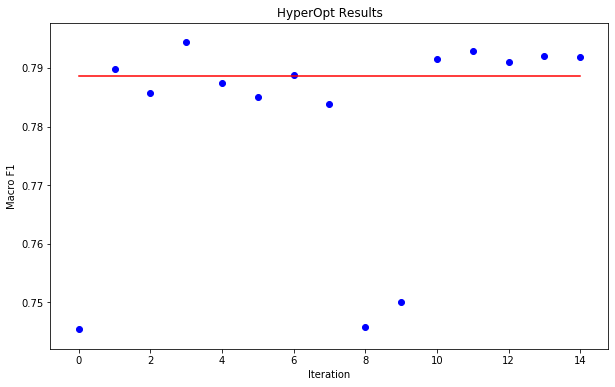

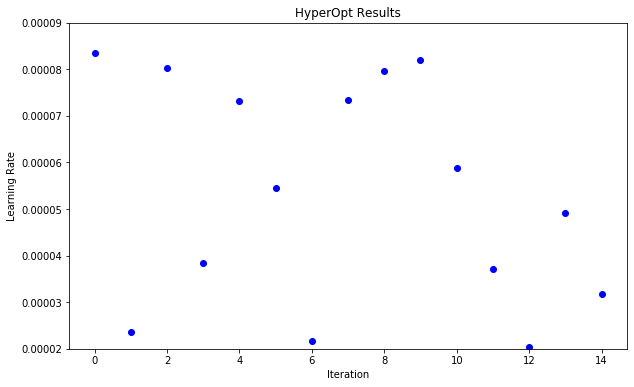

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



figure(figsize=(10, 6))

x = np.arange(15)
y = [-t['result']['loss'] for t in trials.trials]


plt.scatter(x, y, color="blue")

plt.title('HyperOpt Results')
plt.xlabel('Iteration')
plt.ylabel('Macro F1')
plt.show()

figure(figsize=(10, 6))
ax = plt.gca()
x = np.arange(15)
y = [t['misc']['vals']['learning_rate'][0] for t in trials.trials]


plt.scatter(x, y, color="blue")

ax.set( ylim=(0.00002, 0.00009))

plt.title('HyperOpt Results')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.show()